<a href="https://colab.research.google.com/github/RedDirtHenry/NFL/blob/main/NFL_Sack_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install nfl_data_py
#!pip install pandas
#!pip install os
#!pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install sklearn
# !pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=636262ae358b5925e28e87272297c59d263c92f6843cadc974568a9e1297188d
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [ ]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [ ]:
pbp = nfl.import_pbp_data([2022])

2022 done.
Downcasting floats.


In [ ]:
pbp.shape

(50147, 384)

In [ ]:
print(pbp.columns.tolist())

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

In [ ]:
pbp.dtypes

play_id            float32
game_id             object
old_game_id         object
home_team           object
away_team           object
                    ...   
players_on_play     object
offense_players     object
defense_players     object
n_offense            int32
n_defense            int32
Length: 384, dtype: object

In [ ]:
pbp.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,1.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,None,None,None,...,None,None,NaN,None,NaN,,,,0,0
1,43.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,None,None,NaN,None,NaN,47969;53059;42500;46279;53575;48364;46253;5460...,00-0036157;00-0035202;00-0037984;00-0029597;00...,00-0035537;00-0032134;00-0034419;00-0036500;00...,11,11
2,68.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",NaN,53536;43586;53443;42371;42500;44999;43433;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11
3,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SHOTGUN,"1 RB, 2 TE, 2 WR",6.0,"3 DL, 4 LB, 4 DB",4.0,53536;43586;42371;53443;42500;44999;43433;3309...,00-0036924;00-0032466;00-0032234;00-0036979;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11
4,115.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",NaN,53536;43586;53443;42371;42500;44999;43433;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11


In [ ]:
pbp_rp = pbp[(pbp['pass']==1) | (pbp['rush']==1)]
pbp_rp = pbp_rp.dropna(subset=['epa','posteam','defteam'])
pbp_rp = pbp_rp[(pbp['season_type']=='REG')]
pbp_rp.shape

<ipython-input-13-9805dd27467a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pbp_rp = pbp_rp[(pbp['season_type']=='REG')]


(35157, 384)

In [ ]:
pass_epa = pbp_rp[(pbp_rp['pass_attempt']==1)].groupby('posteam')['epa'].mean().reset_index().rename(columns={'epa':'pass_epa'})
qb_passepa = pbp_rp[(pbp_rp['pass_attempt']==1)].groupby('passer_player_name')['epa'].mean().reset_index().rename(columns={'epa':'qb_pass_epa'})
qb_cpoe = pbp_rp[(pbp_rp['pass_attempt']==1)].groupby('passer_player_name')['cpoe'].mean().reset_index().rename(columns={'cpoe':'qb_cpoe'})
qb_passattempts = pbp_rp[(pbp_rp['pass_attempt']==1)].groupby('passer_player_name')['pass_attempt'].count().reset_index()

In [ ]:
qb_stats = pd.merge(qb_passepa, qb_cpoe, on='passer_player_name')
qb_stats = pd.merge(qb_stats, qb_passattempts, on='passer_player_name')
qb_stats = qb_stats[(qb_stats['pass_attempt'] > 150)]
qb_stats

,passer_player_name,qb_pass_epa,qb_cpoe,pass_attempt
2,A.Dalton,0.018023,0.709423,404
4,A.Rodgers,-0.031817,0.516149,575
10,B.Mayfield,-0.155750,-7.031345,371
12,B.Purdy,0.201951,-0.899894,181
25,C.Rush,-0.089331,-6.849936,168
27,C.Wentz,-0.129196,-3.710625,309
31,D.Carr,0.024018,-3.039264,532
35,D.Jones,0.009743,2.320693,514
36,D.Mills,-0.145128,-3.841448,511
37,D.Prescott,0.088990,0.062283,414


In [ ]:
rush_epa = pbp_rp[(pbp_rp['rush']==1)].groupby('posteam')['epa'].mean().reset_index().rename(columns={'epa':'rush_epa'})
epa = pd.merge(pass_epa,rush_epa, on='posteam')
epa.head()

,posteam,pass_epa,rush_epa
0,ARI,-0.132141,-0.079682
1,ATL,-0.028608,0.006186
2,BAL,-0.061358,0.036325
3,BUF,0.137615,-0.063543
4,CAR,-0.096923,-0.006957


In [ ]:
logos = nfl.import_team_desc()[['team_abbr','team_logo_espn']]
logo_paths = []
team_abbr = []

if not os.path.exists("logos"):
  os.makedirs("logos")

for team in range(len(logos)):
  urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
  logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
  team_abbr.append(logos['team_abbr'][team])

data = {'team_abbr':team_abbr, 'logo_path': logo_paths}
logo_data = pd.DataFrame(data)
epa_logos = pd.merge(epa, logo_data, left_on='posteam', right_on='team_abbr')
epa_logos.head()

,posteam,pass_epa,rush_epa,team_abbr,logo_path
0,ARI,-0.132141,-0.079682,ARI,logos/ARI.tif
1,ATL,-0.028608,0.006186,ATL,logos/ATL.tif
2,BAL,-0.061358,0.036325,BAL,logos/BAL.tif
3,BUF,0.137615,-0.063543,BUF,logos/BUF.tif
4,CAR,-0.096923,-0.006957,CAR,logos/CAR.tif


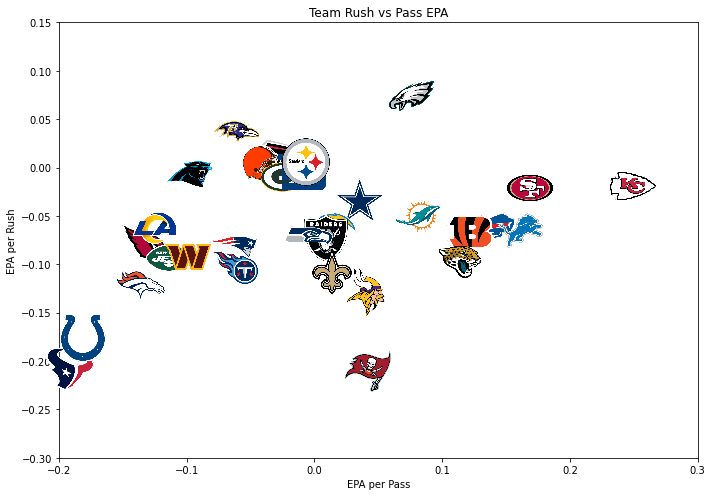

In [ ]:
plt.rcParams["figure.figsize"] = [10,7]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
  return OffsetImage(plt.imread(path, format='tif'), zoom=0.1)

x = epa_logos['pass_epa']
y = epa_logos['rush_epa']
paths = epa_logos['logo_path']

fig, ax = plt.subplots()

for x0, y0, path in zip(x, y, paths):
  ab = AnnotationBbox(getImage(path), (x0, y0), frameon = False)
  ax.add_artist(ab)

plt.xlim(-0.2, 0.3)
plt.ylim(-0.3,0.15)
plt.title('Team Rush vs Pass EPA')
plt.xlabel('EPA per Pass')
plt.ylabel('EPA per Rush')
plt.show()

In [ ]:
receiver_yac = pbp_rp[(pbp_rp['pass']==1)].groupby('receiver_player_name').agg({'pass':'count',
'yards_after_catch':'sum'}).reset_index().rename(columns = {'receiver_player_name':'player','pass':'targets', 'yards_after_catch':'YAC'})
receiver_yac = receiver_yac[(receiver_yac['targets'] >= 100)]
receiver_yac.sort_values('YAC',inplace=True)

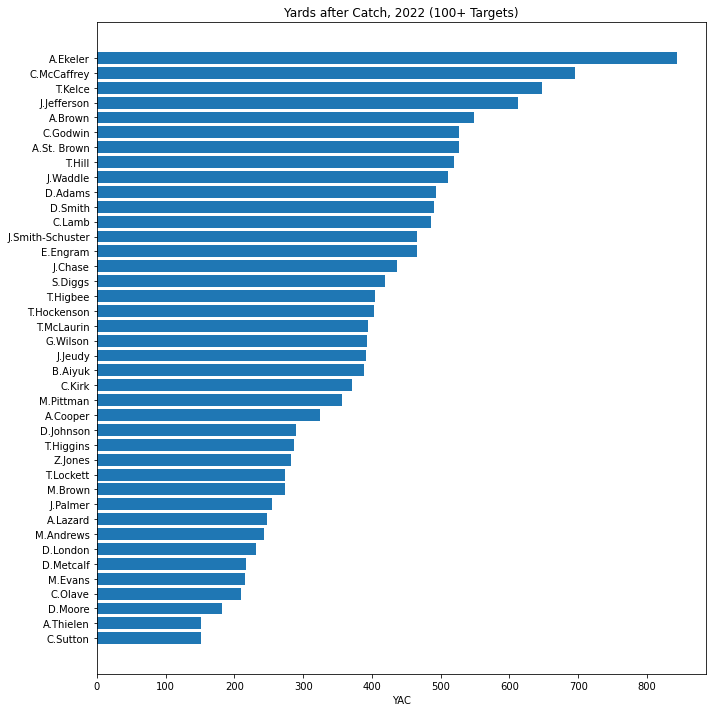

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(receiver_yac['player'], receiver_yac['YAC'])
ax.set_title('Yards after Catch, 2022 (100+ Targets)')
ax.set_xlabel('YAC')
plt.show()

In [ ]:
pbp = nfl.import_pbp_data([2020,2021,2022])

2020 done.
2021 done.
2022 done.
Downcasting floats.


In [ ]:
print(pbp.shape)

(149373, 384)


In [ ]:
pbp = pbp[(pbp['pass']==1) & (pbp['play_type']!='no_play')]
print(pbp.shape)

(64411, 384)


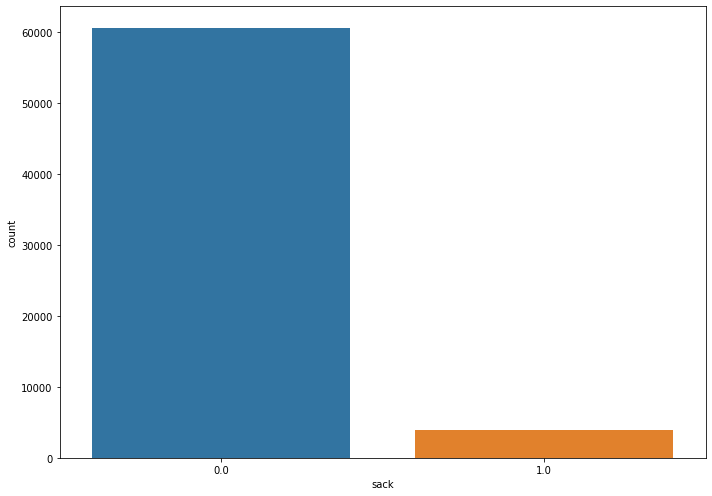

In [ ]:
sns.countplot(x=pbp['sack'])
plt.show()

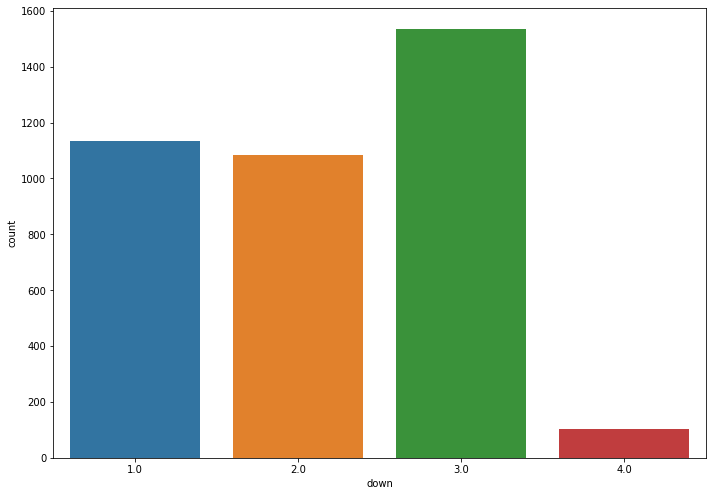

In [ ]:
sacks = pbp[(pbp['sack']==1)]
sns.countplot(x=sacks['down'])
plt.show()

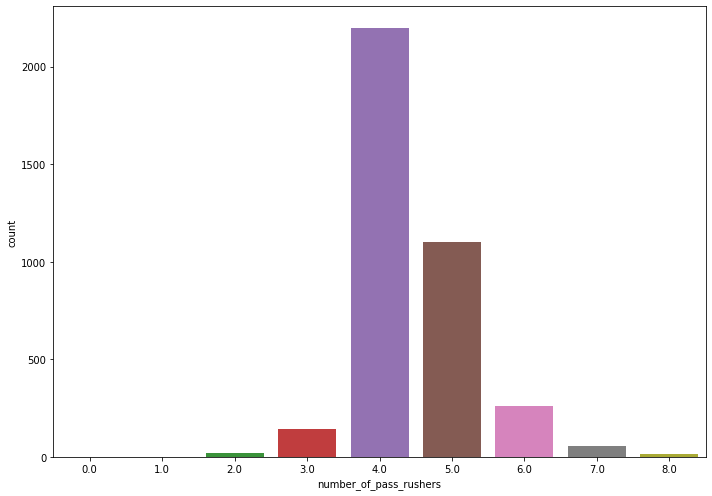

In [ ]:
sns.countplot(x = sacks['number_of_pass_rushers'])
plt.show()

In [ ]:
pbp['obvious_pass'] = np.where((pbp['down']==3) & (pbp['ydstogo'] >= 6), 1, 0)

In [ ]:
pre_df = pbp[['game_id', 'play_id', 'season', 'name', 'down', 'ydstogo',
              'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
              'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack']]
pre_df.isna().sum()

game_id                      0
play_id                      0
season                       0
name                         7
down                       307
ydstogo                      0
yardline_100                 0
game_seconds_remaining       0
defenders_in_box           886
number_of_pass_rushers    3950
xpass                      307
obvious_pass                 0
sack                         0
dtype: int64

In [ ]:
df = pre_df.dropna()
df.head()

,game_id,play_id,season,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack
2,2020_01_ARI_SF,54.0,2020,J.Garoppolo,1.0,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0
6,2020_01_ARI_SF,165.0,2020,J.Garoppolo,3.0,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0
9,2020_01_ARI_SF,245.0,2020,K.Murray,1.0,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0
10,2020_01_ARI_SF,274.0,2020,K.Murray,2.0,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0
11,2020_01_ARI_SF,298.0,2020,K.Murray,1.0,10.0,65.0,3360.0,6.0,4.0,0.453060,0,0.0


In [ ]:
df['down'] = df['down'].astype('category')
df_no_ids = df.drop(columns = ['game_id', 'play_id','name','season'])
df_no_ids = pd.get_dummies(df_no_ids, columns=['down'])

<ipython-input-40-d77381e1f3ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['down'] = df['down'].astype('category')


Index(['ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
       'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack', 'down_1.0',
       'down_2.0', 'down_3.0', 'down_4.0'],
      dtype='object')

In [ ]:
df_no_ids.columns

Index(['ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
       'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack', 'down_1.0',
       'down_2.0', 'down_3.0', 'down_4.0'],
      dtype='object')

In [ ]:
df_no_ids.head()

,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack,down_1.0,down_2.0,down_3.0,down_4.0
2,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0,1,0,0,0
6,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0,0,0,1,0
9,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0,1,0,0,0
10,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0,0,1,0,0
11,10.0,65.0,3360.0,6.0,4.0,0.453060,0,0.0,1,0,0,0


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(df_no_ids, df_no_ids['sack']):
  strat_train_set = df_no_ids.iloc[train_index]
  strat_test_set = df_no_ids.iloc[test_index]

X_train = strat_train_set.drop(columns=['sack'])
Y_train = strat_train_set['sack']
X_test = strat_test_set.drop(columns=['sack'])
Y_test = strat_test_set['sack']

In [ ]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)
LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns=['no_sack','sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, LR_pred))

Brier Score:  0.058702925479582696


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train,Y_train)

RF_pred = pd.DataFrame(RF.predict_proba(X_test), columns=['no_sack','sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, RF_pred))

Brier Score:  0.062166743531328374


In [ ]:
XGB = XGBClassifier(objective='binary:logistic',random_state=88)
XGB.fit(X_train, Y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns=['no_sack','sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, XGB_pred))

Brier Score:  0.05810016170823849


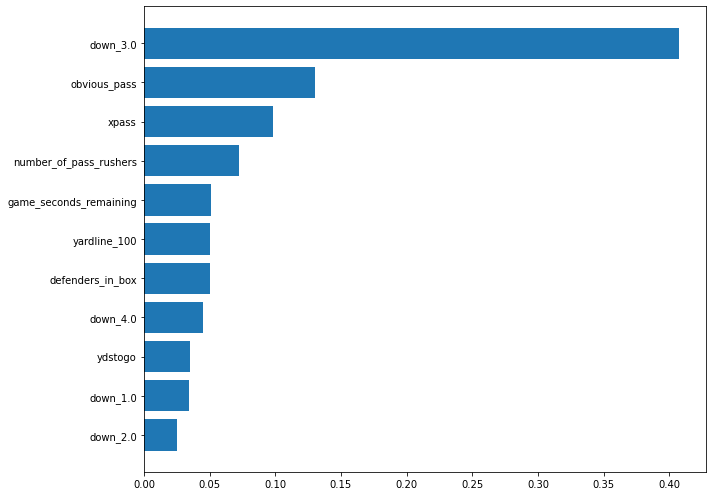

In [ ]:
sorted_idx = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.show()

In [ ]:
make_sacks_preds = df_no_ids.drop('sack',axis=1)
XGB_total_predictions = pd.DataFrame(XGB.predict_proba(make_sacks_preds), columns=['no_sack','sack_pred'])[['sack_pred']]

sacks_preds = df.reset_index().drop(columns=['index'])
sacks_preds['sack_pred'] = XGB_total_predictions

sacks_preds['sacks_oe'] = sacks_preds['sack'] - sacks_preds['sack_pred']
sacks_preds[(sacks_preds['season']==2022)].groupby('name').agg({'sack':'sum', 'sack_pred':'sum', 'sacks_oe':'sum'}).reset_index().sort_values('sacks_oe', ascending=True)

,name,sack,sack_pred,sacks_oe
94,T.Brady,24.0,49.052429,-25.052429
51,J.Goff,23.0,38.857712,-15.857711
83,P.Mahomes,29.0,42.742352,-13.742353
100,T.Lawrence,31.0,43.796589,-12.796588
34,D.Prescott,22.0,30.912537,-8.912537
...,...,...,...,...
86,R.Tannehill,33.0,24.129829,8.870171
8,B.Mayfield,36.0,24.770863,11.229136
32,D.Jones,52.0,37.747105,14.252894
87,R.Wilson,55.0,35.176273,19.823727


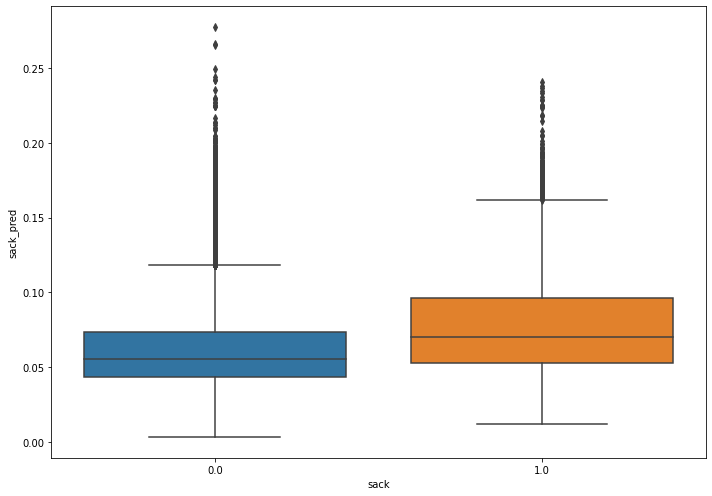

In [ ]:
sns.boxplot(x = sacks_preds['sack'], y=sacks_preds['sack_pred'])
plt.show()